# 📈 **AI Linear Regression** 🚀

chapter 1: **PyTorch Workflow Fundamentals**

https://www.youtube.com/watch?v=Z_ikDlimN6A

# Imports

In [1]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'1.12.1+cu113'

# Device-agnostic setup

In [2]:
# If we have a GPU, our code will use it for faster computing
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")

# Check GPU type
!nvidia-smi

Using device: cuda

Sun Nov  6 23:15:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

# Data preparation

In [3]:
# Known parameters
weight = 0.7
bias = 0.3

# Range values
start = 0
end = 1
step = 0.02

# Features and lables
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 

print(
f'''
    X set:
    {X[:10]}

    y set:
    {y[:10]}
'''
)


    X set:
    tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

    y set:
    tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])



# Splitting train/test


In [4]:
# Create training and testing set
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:] 


print(
f'''
    X_train length: {len(X_train)}
    X_test length: {len(X_test)}
    
    y_train length: {len(y_train)}
    y_test length: {len(y_test)}
'''
)


    X_train length: 40
    X_test length: 10
    
    y_train length: 40
    y_test length: 10



# Data visualization

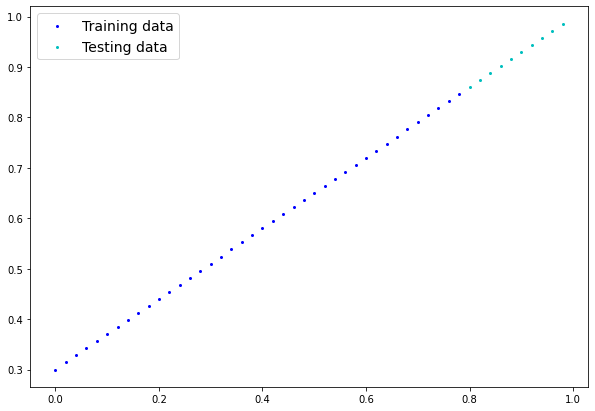

In [5]:
def visualize(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None):
    
    """ Plots training data, test data and compares predictions """

    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in cyan
    plt.scatter(test_data, test_labels, c="c", s=4, label="Testing data")

    # Plot the predictions in red if they exist
    if predictions is not None: 
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  
    # Show the legend
    plt.legend(prop={"size": 14});

visualize();

# Model building

In [6]:
from torch import nn

class LinearRegressionModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)          
    
# this is how the model is implemented under the hood
class NaiveRegressionModel(nn.Module):

    def __init__(self):
        super().__init__()
        # we start with a random weight parameters, they are updated via gradient descent
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) 
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float)) 
    
    # Forward methoddefines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight * x + self.bias 

# Parameter exploration

In [7]:
# Create model and list name parameters
torch.manual_seed(42)
model = LinearRegressionModel()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

# Optimize for Device

In [8]:
# Check Model current device
next(model.parameters()).device

device(type='cpu')

In [9]:
# Set the model to target device
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [10]:
# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
print(f"successfully moved data to device:{device}")

successfully moved data to device:cuda


# Prediction with untrained model


    target weight: 0.7
    predicted weight: 0.7645385265350342
    
    target bias: 0.3
    predicted bias: 0.8300079107284546

    target y:
    tensor([[1.4416],
        [1.4569],
        [1.4722],
        [1.4875],
        [1.5028],
        [1.5181],
        [1.5334],
        [1.5487],
        [1.5640],
        [1.5793]])

    predicted y:
    tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])



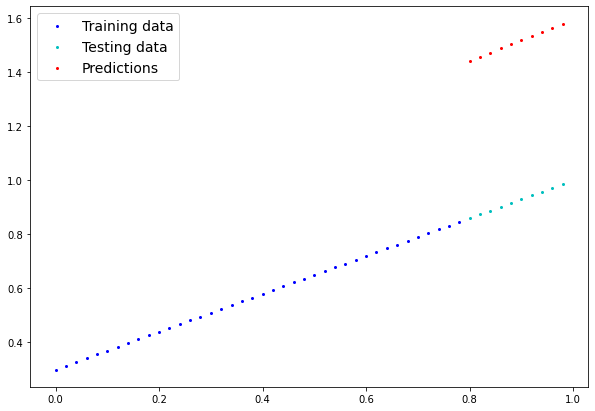

In [11]:
model.eval()
with torch.inference_mode(): y_preds = model(X_test)
visualize(predictions=y_preds.cpu())

print(
f'''
    target weight: {weight}
    predicted weight: {model.state_dict()['linear_layer.weight'].item()}
    
    target bias: {bias}
    predicted bias: {model.state_dict()['linear_layer.bias'].item()}

    target y:
    {y_preds.cpu()}

    predicted y:
    {y_test.cpu()}
'''
)

# Training the model

In [12]:
# set reproducibility (seed)
torch.manual_seed(42)

# Loss function - mean absolute error (L1 loss)
loss_fn = nn.L1Loss()

# Stochastic gradient descent with learning rate 0.01
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01) 

# model progress tracking
epochs = 250
epoch_count = [] 
loss_values = []
test_loss_values = [] 

# Training & testing loop
for epoch in range(epochs + 1): 

    # Training Mode (sets all parameters to require grad)
    model.train() 

    # 1. Forward pass (feeds training data to forward())
    y_pred = model(X_train)

    # 2. Calculate the loss (how wrong is the model)
    loss = loss_fn(y_pred, y_train)

    # 3. Clears the gradients (they accumulate by default)
    optimizer.zero_grad() 

    # 4. Back-propagation (calculates grad of each parameter)
    loss.backward()

    # 5. Gradient-descent (updates model parameters)
    optimizer.step() 

    # Evaluation Mode (turns off certain functionalities)
    model.eval() 

    with torch.inference_mode():
        # 1. Do the forward pass 
        test_pred = model(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    # Display information output
    if epoch % 20 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        weight_pred = model.state_dict()['linear_layer.weight'].item()
        bias_pred = model.state_dict()['linear_layer.bias'].item()
        print(f"Epoch: {epoch}  |  Loss: {loss}  |  Test loss: {test_loss}")
        print(f"Weight: {weight_pred}  |  Bias: {bias_pred}\n")

Epoch: 0  |  Loss: 0.5551779866218567  |  Test loss: 0.5739762187004089
Weight: 0.7606385350227356  |  Bias: 0.8200079202651978

Epoch: 20  |  Loss: 0.3247582018375397  |  Test loss: 0.30455657839775085
Weight: 0.6826387047767639  |  Bias: 0.620008111000061

Epoch: 40  |  Loss: 0.09433845430612564  |  Test loss: 0.03513690456748009
Weight: 0.6046388745307922  |  Bias: 0.4200083017349243

Epoch: 60  |  Loss: 0.019956795498728752  |  Test loss: 0.045803118497133255
Weight: 0.6024590134620667  |  Bias: 0.34100836515426636

Epoch: 80  |  Loss: 0.013089174404740334  |  Test loss: 0.02994490973651409
Weight: 0.6365691423416138  |  Bias: 0.3265085518360138

Epoch: 100  |  Loss: 0.006215683650225401  |  Test loss: 0.014086711220443249
Weight: 0.6706792712211609  |  Bias: 0.31200873851776123

Epoch: 120  |  Loss: 0.0012645035749301314  |  Test loss: 0.013801801018416882
Weight: 0.6929093599319458  |  Bias: 0.2925088703632355

Epoch: 140  |  Loss: 0.0012645035749301314  |  Test loss: 0.013801801

# Predictions with trained model


    target weight: 0.7
    predicted weight: 0.6929093599319458
    
    target bias: 0.3
    predicted bias: 0.2925088703632355

    target y:
    tensor([[0.8468],
        [0.8607],
        [0.8746],
        [0.8884],
        [0.9023],
        [0.9161],
        [0.9300],
        [0.9438],
        [0.9577],
        [0.9716]])

    predicted y:
    tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])



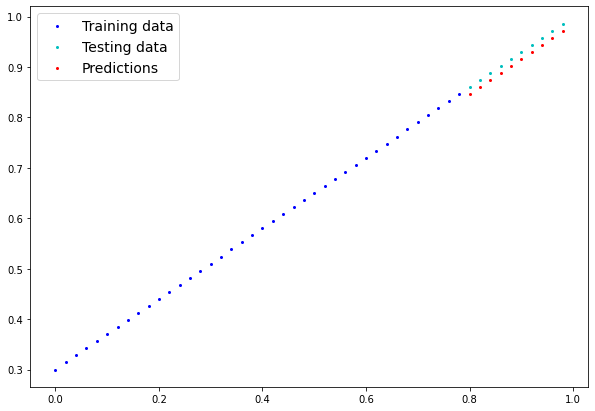

In [13]:
model.eval()
with torch.inference_mode(): y_preds = model(X_test)

visualize(predictions=y_preds.cpu())

print(
f'''
    target weight: {weight}
    predicted weight: {model.state_dict()['linear_layer.weight'].item()}
    
    target bias: {bias}
    predicted bias: {model.state_dict()['linear_layer.bias'].item()}

    target y:
    {y_preds.cpu()}

    predicted y:
    {y_test.cpu()}
'''
)


# Loss curves

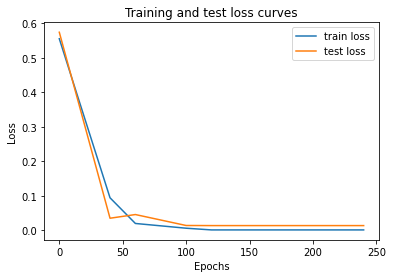

In [14]:
# Turn tensor into numpy array
loss_values = torch.tensor(loss_values).cpu().numpy()
test_loss_values = torch.tensor(test_loss_values).cpu().numpy()

# Plot the loss curves
plt.plot(epoch_count, loss_values, label="train loss")
plt.plot(epoch_count, test_loss_values, label="test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

# Saving the model

In [15]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(model.state_dict(), MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [16]:
# Check if model is present
!ls -l models

total 4
-rw-r--r-- 1 root root 1127 Nov  6 23:15 01_pytorch_workflow_model_1.pth


# Loading the Model

In [17]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model = LinearRegressionModel()

# Load the saved state_dict of model (updated parameters)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [18]:
next(loaded_model.parameters()).device

device(type='cuda', index=0)

In [19]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6929]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2925], device='cuda:0'))])

In [20]:
# Make some predictions with our loaded model
loaded_model.eval()
with torch.inference_mode(): loaded_model_preds = loaded_model(X_test)

# Compare loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')